# Image metadata

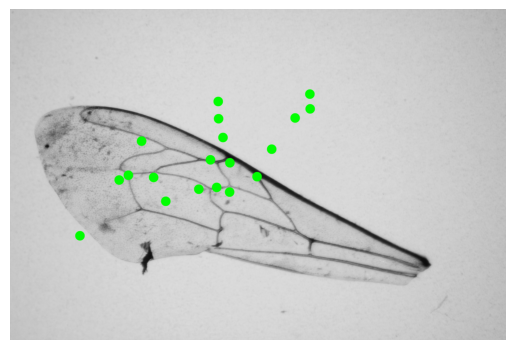

In [3]:
import cv2
import numpy as np
import torch
from PIL import Image

from wings.config import RAW_DATA_DIR
from wings.visualizing.visualize import visualize_coords

# open the image
path = RAW_DATA_DIR / "skrzydła-BM" / "1" / ".dw.dw.png.dw.png"
image = Image.open(path)
image.load()

s = image.info['IdentiFly']

part = s.split("landmarks:")[1].split(";")[0]

# zamień na listę liczb
numbers = [int(x) for x in part.split()]
# ułóż w tablicę (n, 2)
landmarks = np.array(numbers).reshape(-1, 2)

# print(landmarks)

img = cv2.imread(path, cv2.IMREAD_COLOR)
img = visualize_coords(img, torch.tensor(numbers), spot_size=50)


In [4]:
from wings.modeling.loss import DiceLoss
from wings.modeling.litnet import LitNet
from wings.config import PROCESSED_DATA_DIR, MODELS_DIR
import torch

mean_coords = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "mean_shape.pth", weights_only=False
)

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()


Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

In [10]:
from tqdm import tqdm
import os
from wings.config import RAW_DATA_DIR
from wings.gpa import recover_order
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess, final_coords
from wings.utils import load_image
from PIL import Image
import numpy as np
import torch

original_labels = []
predicted_labels = []
bad_masks = 0
bad_indices = []

directory = RAW_DATA_DIR / "skrzydła-BM"

all_files = []
for subdir, _, files in os.walk(directory):
    for file in files:
        if file.lower().endswith('.png'):
            img_path = os.path.join(subdir, file)
            all_files.append(img_path)

for idx, img_path in enumerate(tqdm(all_files, desc="Processing images")):
    try:
        image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
        output = model(image_tensor.cuda().unsqueeze(0))
        mask = torch.round(output).squeeze().detach().cpu().numpy()

        mask_coords = final_coords(mask, x_size, y_size)
        reordered = recover_order(mean_coords, torch.tensor(mask_coords))
        predicted_labels.append(reordered.cpu().numpy())

        img = Image.open(img_path)
        img.load()
        meta = img.info['IdentiFly']
        orig = meta.split("landmarks:")[1].split(";")[0]
        labels = [int(x) for x in orig.split()]
        coordinates = np.array(labels).reshape(-1, 2)
        coordinates[:, 1] = y_size - coordinates[:, 1] - 1
        original_labels.append(coordinates)

    except Exception:
        bad_masks += 1
        bad_indices.append(idx)
        continue

print(f"Total samples: {len(original_labels) + bad_masks}")
print(f"Failed masks: {bad_masks}")

original_labels = np.stack(original_labels)
predicted_labels = np.stack(predicted_labels)

print(f"original_labels.shape = {original_labels.shape}")
print(f"predicted_labels.shape = {predicted_labels.shape}")


Processing images: 100%|██████████| 125/125 [01:03<00:00,  1.97it/s]

Total samples: 125
Failed masks: 67
original_labels.shape = (58, 19, 2)
predicted_labels.shape = (58, 19, 2)


In [11]:
errors = np.linalg.norm(predicted_labels - original_labels, axis=2)  # shape: (n_samples, 19)
errors.size


1102

In [12]:
import pandas as pd

mean = errors.mean()
median = np.median(errors)

mean_error = errors.mean(axis=0)
min_error = errors.min(axis=0)
max_error = errors.max(axis=0)

rmse_error = np.sqrt(np.mean(errors ** 2, axis=0))
median_error = np.median(errors, axis=0)

df = pd.DataFrame(
    {
        "MAE": mean_error,
        "RMSE": rmse_error,
        "Median": median_error,
        "Min": min_error,
        "Max": max_error,
    }, index=np.arange(1, 20)
)

print(f"{mean=}")
print(f"{median=}\n")

df.index.name = "Point"
df = df.round(3)

print(df)


mean=np.float64(19.199511814225605)
median=np.float64(12.473756723529966)

          MAE     RMSE  Median    Min      Max
Point                                         
1      27.128   91.899  12.901  0.747  675.908
2      19.398   40.280  12.393  2.289  262.373
3      21.866   56.532  12.732  2.604  333.104
4      23.120   55.059  13.338  1.432  287.142
5      12.158   13.329  12.116  1.340   25.694
6      12.304   13.946  10.808  0.789   29.409
7      15.509   16.836  15.477  4.471   27.891
8      11.691   13.163  11.570  0.908   24.676
9      13.148   24.411  10.080  2.403  162.991
10     20.265   78.071   9.581  0.285  588.395
11     14.320   15.647  13.138  2.121   29.516
12     14.977   16.702  13.205  2.522   37.883
13     12.573   14.487  11.751  1.021   38.689
14     19.392   21.645  18.461  3.383   59.257
15     19.671   53.119  11.817  2.885  389.071
16     27.708   75.094  14.917  1.161  431.240
17     17.182   37.777  10.216  0.330  203.325
18     16.950   27.860  12.816  

In [13]:
mean_per_image = errors.mean(axis=1)
# mean_per_image = np.sqrt(np.mean(errors**2, axis=1))

mae = np.mean(np.abs(mean_per_image))
rmse = np.sqrt(np.mean(mean_per_image ** 2))
median_error = np.median(mean_per_image)
min_error = np.min(mean_per_image)
max_error = np.max(mean_per_image)

df = pd.DataFrame(
    {
        "MAE": [mae],
        "RMSE": [rmse],
        "Median": [median_error],
        "Min": [min_error],
        "Max": [max_error]
    }
).round(3)

print(df)


    MAE    RMSE  Median     Min      Max
0  19.2  28.409  13.159  10.736  106.511


In [14]:
import numpy as np

n = 10

flat_errors = errors.flatten()

# Get indices of top-n largest errors
top_n_flat_indices = np.argpartition(-flat_errors, n)[:n]
top_n_flat_indices = top_n_flat_indices[np.argsort(-flat_errors[top_n_flat_indices])]

# Convert back to 2D indices (sample index, inner index)
top_n_indices_2d = np.array(np.unravel_index(top_n_flat_indices, errors.shape)).T  # shape: (n, 2)
top_n_sample_indices = top_n_indices_2d[:, 0]

all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if i not in bad_indices]

original_dataset_indices_per_point = [good_indices[i] for i in top_n_sample_indices]

print("Top-n errors (dataset_index, point, error_value):")
for idx, ((sample_idx, inner_idx), dataset_idx) in enumerate(zip(top_n_indices_2d, original_dataset_indices_per_point)):
    print(
        f"{idx + 1:2.0f}:\tIndex={dataset_idx:5.0f}\t\tPoint {inner_idx+1:2.0f}\tError={errors[sample_idx, inner_idx]:7.2f}"
    )

print(original_dataset_indices_per_point)


Top-n errors (dataset_index, point, error_value):
 1:	Index=   50		Point 19	Error= 714.52
 2:	Index=   78		Point 19	Error= 714.20
 3:	Index=   70		Point  1	Error= 675.91
 4:	Index=   68		Point 10	Error= 588.40
 5:	Index=   70		Point 19	Error= 521.14
 6:	Index=   68		Point 16	Error= 431.24
 7:	Index=   68		Point 15	Error= 389.07
 8:	Index=    8		Point 16	Error= 356.22
 9:	Index=   50		Point  3	Error= 333.10
10:	Index=   50		Point  4	Error= 287.14
[50, 78, 70, 68, 70, 68, 68, 8, 50, 50]


In [15]:
import numpy as np

n = 10

mean_errors_per_image = np.mean(errors, axis=1)  # shape: (n_images,)

top_n_indices = np.argpartition(-mean_errors_per_image, n)[:n]
top_n_indices = top_n_indices[np.argsort(-mean_errors_per_image[top_n_indices])]

all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if i not in bad_indices]
original_dataset_indices_per_image = [good_indices[i] for i in top_n_indices]

print("Top-n images with largest mean error (dataset_index, mean_error):")
for rank, (sample_idx, dataset_idx) in enumerate(zip(top_n_indices, original_dataset_indices_per_image), start=1):
    print(f"{rank:2}: Index={dataset_idx:5}\t\tMean error={mean_errors_per_image[sample_idx]:7.3f}")


Top-n images with largest mean error (dataset_index, mean_error):
 1: Index=   68		Mean error=106.511
 2: Index=   70		Mean error=106.456
 3: Index=   50		Mean error= 96.481
 4: Index=   78		Mean error= 56.622
 5: Index=    8		Mean error= 46.664
 6: Index=   40		Mean error= 18.398
 7: Index=   31		Mean error= 17.148
 8: Index=   86		Mean error= 16.595
 9: Index=   91		Mean error= 16.558
10: Index=  114		Mean error= 16.540


In [16]:
threshold = 3.5

num_errors_above_threshold = np.sum(errors > threshold)
total_points = errors.size
percentage = (num_errors_above_threshold / total_points) * 100

print(f"Number of points with error > {threshold}: {num_errors_above_threshold}")
print(f"Percent of all points: {percentage:.2f}%")


Number of points with error > 3.5: 1044
Percent of all points: 94.74%


In [19]:
threshold = 30

mean_errors_per_image = np.mean(errors, axis=1)

num_images_above_threshold = np.sum(mean_errors_per_image > threshold)
total_images = len(mean_errors_per_image)
percentage = (num_images_above_threshold / total_images) * 100

print(f"Number of images with mean error > {threshold}: {num_images_above_threshold}")
print(f"Percent of all images: {percentage:.2f}%")


Number of images with mean error > 30: 5
Percent of all images: 8.62%


In [44]:
max_n = len(good_indices)
values = range(0, max_n)
values_iter = iter(values)


In [1]:
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
from wings.config import RAW_DATA_DIR, IMG_FOLDER_SUFX

# n = np.random.randint(0, max_n)
# n = 728
try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)


img_path = all_files[good_indices[n]]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(x_size, y_size)
output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()

mask_coords = final_coords(mask, x_size, y_size)
reordered = recover_order(mean_coords, torch.tensor(mask_coords))

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1


# Visualize
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 30
print(n)
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)
img = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")


2025-10-27 17:11:21.313 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-10-27 17:11:21.395 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


NameError: name 'values_iter' is not defined